### Baseline experiment

Experiment to compare the 4 Optimization algorithms before trying to improve sparse search

In [1]:
import openml

from openml import tasks

import HPO

import pysgpp

import sys

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn.metrics

from sklearn.model_selection import cross_val_score

import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from scikeras.wrappers import KerasRegressor, KerasClassifier


def to_standard(lower, upper, value):
    return (value-lower)/(upper-lower)


def from_standard(lower, upper, value):
    return value*(upper-lower)+lower

VERBOSE = 0
CV = 2
TESTING = False

ITER = 3

DATASETS = []

GRID_RESULT = []
RANDOM_RESULT = []
BAYESIAN_RESULT = []
SPARSE_RESULT = []
SPARSE_RESULT_OPTIMIZED = []

GRID_COST = []
RANDOM_COST = []
BAYESIAN_COST = []
SPARSE_COST = []
SPARSE_COST_OPTIMIZED = []

2023-04-13 08:05:09.723505: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 08:05:10.987014: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Hyperparameter space definition

In [2]:
hyperparameterspace = {
    'loss': ["list", 'mean_absolute_error', 'mean_squared_error'],
    'epochs': ["interval-int", 1, 20],
    'batch_size': ["interval-int", 40, 160],
    'optimizer': ["list", 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],
    'optimizer__learning_rate': ["interval", 0.0000001, 0.01]
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

In [3]:
ids = [233214, 233211, 359935, 359952]#, 359940, 359931, 317614, 359949, 359934, 359946, 359938, 359932, 359943]

def relu_advanced(x):
    return K.relu(x, max_value=250)

ACTIVATION_FUNCTION = relu_advanced

valid_datasets = 0
for i in range(len(ids)):
    task = tasks.get_task(ids[i])

    # Get dataset by ID
    dataset = task.get_dataset()

    print("Current dataset:", i, "of", len(ids), "with name:", dataset.name)

    # Get the data itself as a dataframe (or otherwise)
    data, target, _, _ = dataset.get_data(dataset.default_target_attribute, dataset_format="array")
    if np.isnan(data).any() or np.isnan(target).any():
        print("NaN detected, skipping dataset")
        continue

    X = torch.Tensor(data)
    Y = torch.Tensor(target)

    dataset = HPO.Dataset(X, Y)

    ################## MODEL AND FUNCTION DEFINITION ####################

    # Function to create model, required for KerasClassifier
    def create_model(): 
        # create model
        model = Sequential()
        model.add(Dense(20, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
        model.add(BatchNormalization())
        model.add(Dense(20, activation=ACTIVATION_FUNCTION))
        model.add(BatchNormalization())
        model.add(Dense(1, activation=ACTIVATION_FUNCTION))
        return model


    def blackboxfunction(params):
        index = int(params[0]*(len(hyperparameterspace_special["loss"])-1))
        loss = hyperparameterspace_special["loss"][index]
        
        epochs = int(params[1])

        batch_size = int(params[2])

        index = int(params[3]*(len(hyperparameterspace_special["optimizer"])-1))
        model_optimizer = hyperparameterspace_special["optimizer"][index]

        model_learning_rate = params[4]

        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(20, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
            model.add(BatchNormalization())
            model.add(Dense(20, activation=ACTIVATION_FUNCTION))
            model.add(BatchNormalization())
            model.add(Dense(1, activation=ACTIVATION_FUNCTION))
            # Compile model
            if model_optimizer == 'SGD':
                optimizer = keras.optimizers.SGD(learning_rate=model_learning_rate)
            elif model_optimizer == 'RMSprop':
                optimizer = keras.optimizers.RMSprop(learning_rate=model_learning_rate)
            elif model_optimizer =='Adagrad':
                optimizer = keras.optimizers.Adagrad(learning_rate=model_learning_rate)
            elif model_optimizer =='Adadelta':
                optimizer = keras.optimizers.Adadelta(learning_rate=model_learning_rate)
            elif model_optimizer =='Adam':
                optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)
            elif model_optimizer =='Adamax':
                optimizer = keras.optimizers.Adamax(learning_rate=model_learning_rate)
            elif model_optimizer == 'Nadam':
                optimizer = keras.optimizers.Nadam(learning_rate=model_learning_rate)


            model.compile(loss=loss, optimizer=optimizer)
            return model

        model = KerasRegressor(model=create_model, verbose=0)

        model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs, batch_size=batch_size)

        if TESTING:
            print("Test set is being used")
            Y_predicted = model.predict(dataset.get_X_test())
            if np.any(np.isnan(Y_predicted)):
                return 1000
            return -sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted)
        else:
            Y_predicted = model.predict(dataset.get_X_validation())
            if np.any(np.isnan(Y_predicted)):
                return 1000
            return -sklearn.metrics.mean_squared_error(dataset.get_Y_validation(), Y_predicted)
        
    ##################### Function for sparse grid search #####################

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(len(hyperparameterspace.keys()))


        def eval(self, x):
            index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            loss = hyperparameterspace_special["loss"][index]
            
            epochs = int(from_standard(hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[1]))

            batch_size = int(from_standard(hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[2]))

            index = int(x[3]*(len(hyperparameterspace_special["optimizer"])-1))
            model_optimizer = hyperparameterspace_special["optimizer"][index]

            model_learning_rate = from_standard(hyperparameterspace_special["optimizer__learning_rate"][0], hyperparameterspace_special["optimizer__learning_rate"][1], x[4])
            
            # Function to create model, required for KerasClassifier
            def create_model():
                # create model
                model = Sequential()
                model.add(Dense(20, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
                model.add(BatchNormalization())
                model.add(Dense(20, activation=ACTIVATION_FUNCTION))
                model.add(BatchNormalization())
                model.add(Dense(1, activation=ACTIVATION_FUNCTION))
                # Compile model
                if model_optimizer == 'SGD':
                    optimizer = keras.optimizers.SGD(learning_rate=model_learning_rate)
                elif model_optimizer == 'RMSprop':
                    optimizer = keras.optimizers.RMSprop(learning_rate=model_learning_rate)
                elif model_optimizer =='Adagrad':
                    optimizer = keras.optimizers.Adagrad(learning_rate=model_learning_rate)
                elif model_optimizer =='Adadelta':
                    optimizer = keras.optimizers.Adadelta(learning_rate=model_learning_rate)
                elif model_optimizer =='Adam':
                    optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)
                elif model_optimizer =='Adamax':
                    optimizer = keras.optimizers.Adamax(learning_rate=model_learning_rate)
                elif model_optimizer == 'Nadam':
                    optimizer = keras.optimizers.Nadam(learning_rate=model_learning_rate)

                model.compile(loss=loss, optimizer=optimizer,)
                return model

            model = KerasRegressor(model=create_model, verbose=0)

            model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs, batch_size=batch_size)

            if TESTING:
                Y_predicted = model.predict(dataset.get_X_test())
                if np.any(np.isnan(Y_predicted)):
                    return 1000
                return sklearn.metrics.mean_squared_error(dataset.get_Y_test().tolist(), Y_predicted)
            else:
                Y_predicted = model.predict(dataset.get_X_validation())
                if np.any(np.isnan(Y_predicted)):
                    return 1000
                return sklearn.metrics.mean_squared_error(dataset.get_Y_validation().tolist(), Y_predicted)
            


    ##### For each dataset: run models with different budget #####

    for j in range(ITER):
        BUDGET = 30 + j * 30       
                

        ############################## GRID SEARCH #######################
        print("Performing grid search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.GridSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        Y_predicted = result.predict(dataset.get_X_test())

        GRID_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        GRID_COST.append(cost)

        ########################### RANDOM SEARCH #######################
        print("Performing random search")
        
        model = KerasRegressor(model=create_model, verbose=0)

        optimization = HPO.RandomSearchOptimization(dataset, model, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, cv=CV)

        result, cost = optimization.fit()

        Y_predicted = result.predict(dataset.get_X_test())

        RANDOM_RESULT.append(sklearn.metrics.mean_squared_error(dataset.get_Y_test(), Y_predicted))
        RANDOM_COST.append(cost)

        ########################### BAYESIAN OPT ##################### 
        print("Performing bayesian optimization")

        optimization = HPO.BayesianOptimization(dataset, blackboxfunction, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE)


        result = optimization.fit()
        
        index_best = 0
        for i in range(len(result[1])):
            if result[1][i] == max(result[1]):
                index_best = i

        best_score = result[1][index_best]
        best_params = result[0][index_best]

        TESTING = True
        BAYESIAN_RESULT.append(-blackboxfunction(best_params))
        TESTING = False

        BAYESIAN_COST.append(BUDGET)


        ########################### SPARSE OPT ############################
        print("Performing sparse search")

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=2, adaptivity=0.95, optimizer="gradient_descent")

        result = optimization.fit()
        

        TESTING = True
        SPARSE_RESULT.append(f.eval(result[0]))
        SPARSE_RESULT_OPTIMIZED.append(f.eval(result[1]))
        TESTING = False

        SPARSE_COST.append(BUDGET)
        SPARSE_COST_OPTIMIZED.append(BUDGET)

    valid_datasets += 1
    



Current dataset: 0 of 4 with name: Santander_transaction_value
Performing grid search


2023-04-13 08:05:14.810002: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-13 08:05:14.810756: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 72.62626612100576 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 120240ms.
Solving linear system (automatic method)...
Done in 1ms.
Optimizing (gradient descent)...
Done in 0ms.
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 222.56794559789705 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 128245ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 199.77124090498546 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 147692ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 1 of 4 with name: diamonds
Performing grid search
Performing random search
Performing bayesian optimization
Iterations took 390.13670287595596 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 450633ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 562.4354506840173 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 461681ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 1623.763590165181 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 667784ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 2 of 4 with name: wine_quality
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 79.12877831301012 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 145174ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 364.7455332790123 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 105957ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Performing grid search
Performing random search
Performing bayesian optimization
Iterations took 764.3109854739741 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 123496ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Current dataset: 3 of 4 with name: house_16H
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: 

Iterations took 166.36342306199367 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 226017ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Performing grid search
Performing random search
Performing bayesian optimization
Iterations took 489.38101208805165 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 226601ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 0ms.
Performing grid search
Performing random search
Performing bayesian optimization


/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/maxi/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Iterations took 1042.2231832419347 seconds
Test set is being used
Performing sparse search
Adaptive grid generation (Ritter-Novak)...
Done in 254795ms.
Solving linear system (automatic method)...
Done in 0ms.
Optimizing (gradient descent)...
Done in 1ms.


Current dataset: 0 with name id: 233214


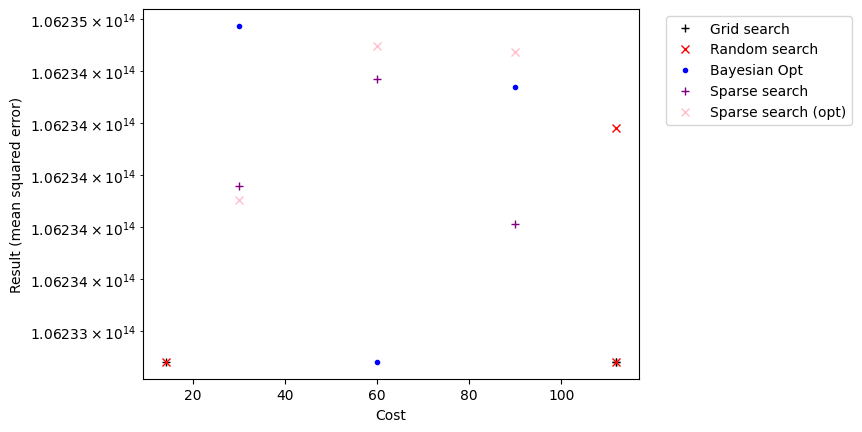

Current dataset: 1 with name id: 233211


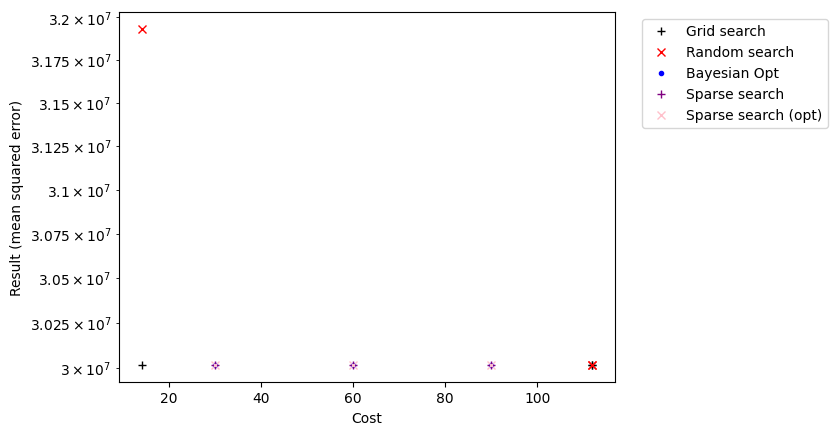

Current dataset: 2 with name id: 359935


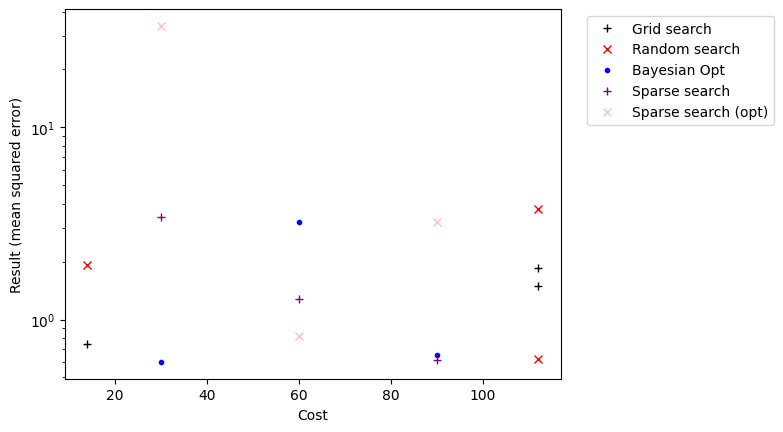

Current dataset: 3 with name id: 359952


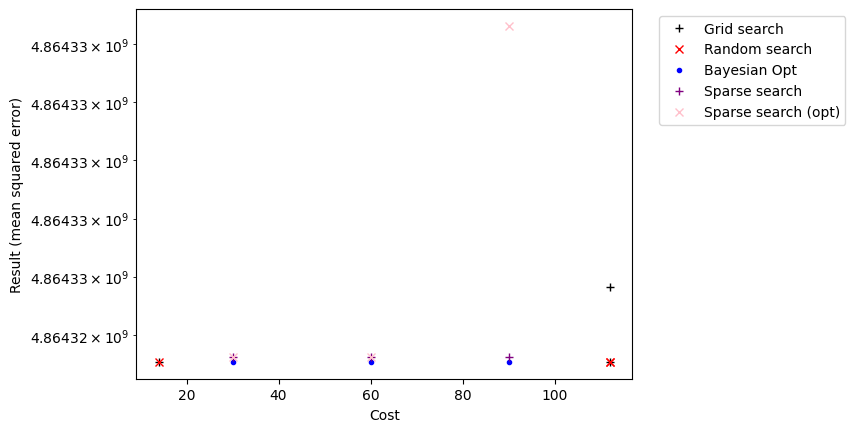

: 

In [6]:
count = 0
for i in range(valid_datasets):
    print("Current dataset:", i, "with name id:", ids[i])
    for j in range(ITER):
        plt.plot(GRID_COST[count], GRID_RESULT[count], '+', color='black')
        plt.plot(RANDOM_COST[count], RANDOM_RESULT[count], 'x', color='red')
        plt.plot(BAYESIAN_COST[count], BAYESIAN_RESULT[count], '.', color='blue')
        plt.plot(SPARSE_COST[count], SPARSE_RESULT[count], '+', color='purple')
        plt.plot(SPARSE_COST_OPTIMIZED[count], SPARSE_RESULT_OPTIMIZED[count], 'x', color='pink')
        plt.xlabel("Cost")
        plt.ylabel("Result (mean squared error)")
        plt.yscale("log")
        plt.legend(["Grid search", "Random search", "Bayesian Opt", "Sparse search", "Sparse search (opt)"], bbox_to_anchor=(1.04, 1), loc="upper left")
        count += 1
    plt.show()

